#### 1. Business Understanding

Based on the happiness reports from year 2015-2019 I would like to understand or answer the following questions

    1.  What are happiest countries in the world?
    2.  What are common amongst these happy countries? What makes these countries happy?
    3.  Are there any anomalies amongst these happy countries?
    4.  What are the happiest countries in the making?
    5.  Is happiness obvious to predict?
    
---------------------------------------------

In [1]:
# Disable jedi autocompleter due to bug in my local version (comment it out if it's not a problem)
# Importing all the necessary libraries
%config Completer.use_jedi = False
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import matplotlib.cm as cm
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression
sns.set_style("dark")

-----------------------------------------------

#### 2. Data Understanding

Some of most important columns of in the data frames are as follows

    1. Trust (Government Corruption) - The extent to which Perception of Corruption contributes to Happiness Score
    2. Family - The extent to which Family contributes to the calculation of the Happiness Score
    3. Health (Life Expectancy) - The extent to which Life expectancy contributed to the calculation of the Happiness Score
    4. Freedom - The extent to which Freedom contributed to the calculation of the Happiness Score
    5. Generosity - The extent to which Generosity contributed to the calculation of the Happiness Score.
    6. Economy (GDP per Capita) - The extent to which GDP contributes to the calculation of the Happiness Score

Additionally the data frames are a mini time series data with happiness scores for each country reported over multiple years.



In [2]:
cols_to_investigate = ['Economy (GDP per Capita)', 'Family', 'Health (Life Expectancy)',
       'Freedom', 'Trust (Government Corruption)', 'Generosity', 'Happiness Score']


----------------------------------------------

#### 3. Preparing the Data

After some initial analysis, some of the columns in the data frames had different column names and also had some noise. Thus this section of cells deals with cleaning the data.

In [3]:
# Cleaning the data

all_files = os.listdir('./data/')
file_names = [file for file in all_files if file.endswith('.csv')]
all_dfs = []
cols_to_drop = ['Standard Error', 'Lower Confidence Interval', 'Upper Confidence Interval', 
                'Region', 'Dystopia Residual', 'Whisker high','Whisker low']
synonymous_cols = {'Perceptions of corruption' : 'Trust (Government Corruption)', 'Social support' : 'Family', 'Score' : 'Happiness Score', 
                    'Rank' : 'Happiness Rank', 'Country or region' : 'Country', 'Health  Life Expectancy ' : 'Health (Life Expectancy)',
                    'Healthy life expectancy' : 'Health (Life Expectancy)', 'Freedom to make life choices' : 'Freedom', 'Overall rank' : 'Happiness Rank',
                    'Economy  GDP per Capita ' : 'Economy (GDP per Capita)', 'GDP per capita' : 'Economy (GDP per Capita)', 'Trust  Government Corruption ': 'Trust (Government Corruption)'}


def preprocess_data_frames(file_names : list):
    '''
    Function to preprocess and load the data frames into the memory
    
    1. Loads each dataframe into the memory
    2. Checks for validity of columns and noise in columns and removes if any
    3. Makes sure all the columns in all the data frames are the same and if not matches the wrong column with the right one
    4. Concatenates all the dataframes and returns it
    
    Args:
        file_names - list of csv files which have to be processed
    
    Returns:
        df: Processed and concatenated dataframes based on input filenames
    
    '''
    
    for each_file in file_names:
        df = pd.read_csv('./data/'+each_file)
        year = each_file.split('.')[0]
        df['Year'] =  year
        df['Train'] = 1 if year != '2019' else 0
        cols = df.columns
        new_cols = [col.replace('.', ' ', 10) for col in cols]
        df.columns = new_cols
        df.drop(cols_to_drop, errors='ignore', inplace=True, axis=1)
        new_cols = [synonymous_cols[col] if col in synonymous_cols.keys() else col for col in df.columns]
        df.columns = new_cols
        all_dfs.append(df)
        
    df = pd.concat(all_dfs, axis=0)
    
    
    print("Concatenated data frame shape: " ,df.shape)
    print("Columns in data frame: ", df.columns)
    return df

df = preprocess_data_frames(file_names)
df.head(5)

Concatenated data frame shape:  (782, 11)
Columns in data frame:  Index(['Country', 'Happiness Rank', 'Happiness Score',
       'Economy (GDP per Capita)', 'Family', 'Health (Life Expectancy)',
       'Freedom', 'Trust (Government Corruption)', 'Generosity', 'Year',
       'Train'],
      dtype='object')


,Country,Happiness Rank,Happiness Score,Economy (GDP per Capita),Family,Health (Life Expectancy),Freedom,Trust (Government Corruption),Generosity,Year,Train
0,Switzerland,1,7.587,1.39651,1.34951,0.94143,0.66557,0.41978,0.29678,2015,1
1,Iceland,2,7.561,1.30232,1.40223,0.94784,0.62877,0.14145,0.43630,2015,1
2,Denmark,3,7.527,1.32548,1.36058,0.87464,0.64938,0.48357,0.34139,2015,1
3,Norway,4,7.522,1.45900,1.33095,0.88521,0.66973,0.36503,0.34699,2015,1
4,Canada,5,7.427,1.32629,1.32261,0.90563,0.63297,0.32957,0.45811,2015,1


----------------------------------------------

#### 4. Data Modelling and Analysis

##### 1. What are happiest countries in the world?

    To answer this question I took an average of happiness score over multiple years and then normalized the mean happiness score.This way it will be easier to understand the plot of happiness landscape.

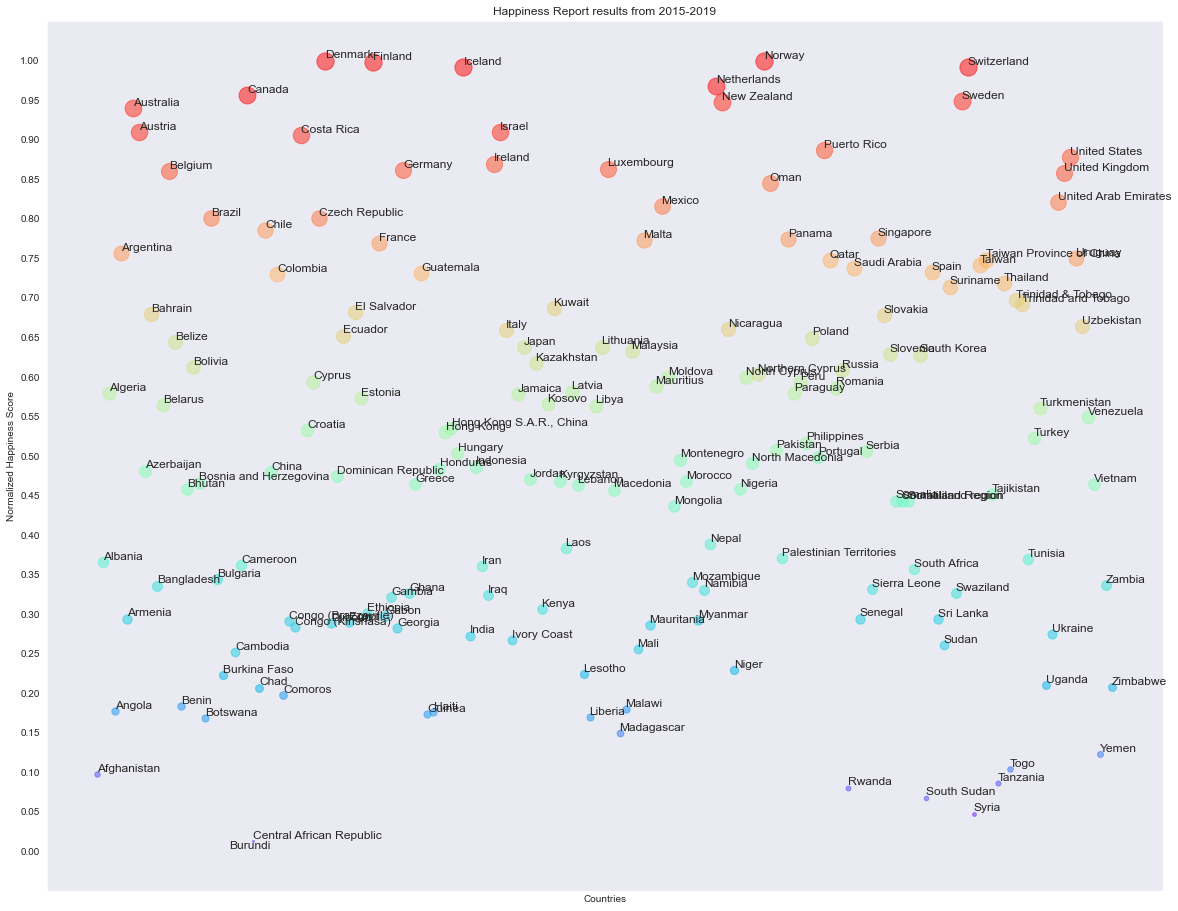

In [4]:
# To prepare mean happiness dataframe from 2015 to 2019
mean_df = df.groupby(['Country'])[['Happiness Score']].mean().reset_index()
min_score = mean_df['Happiness Score'].min()
max_score = mean_df['Happiness Score'].max()
mean_df['score_norm'] = (mean_df['Happiness Score'] - min_score) / (max_score - min_score)

# Plotting the happiness landscape based on the color code from botton to top
all_countries = mean_df['Country'].unique()
colors = cm.rainbow(np.arange(0, 1+0.05, 0.05))
custom_bins = np.arange(0, 1+0.05, 0.05)
plt.figure(figsize=(20, 16))
for i in range(0, len(all_countries)):
    obj = mean_df.iloc[i]
    score, country = obj['score_norm'], obj['Country']
    color_index = np.argwhere(score <= custom_bins)[0][0]
    plt.scatter(i, score, s=300*score, color=colors[color_index], alpha=0.5)
    plt.text(i+.003, score+.003, country, fontsize=12)
plt.yticks(np.arange(0, 1+0.05, 0.05))
plt.xticks([])
plt.xlabel('Countries')
plt.ylabel('Normalized Happiness Score')
plt.title('Happiness Report results from 2015-2019')
plt.savefig('./plots/Report_results.png', bbox_inches='tight')

Getting the happiest countries by name and also preparing the data frame on the basis of ```cols_to_investigate``` to answer the upcoming questions. Additionally, I decided a threshold of 0.8 to be decent cutoff for the happiest countries in the world

In [5]:
# Calculating normalized features over multiple years
df_mean = df.groupby(['Country'])[cols_to_investigate].mean().reset_index()
for col in cols_to_investigate:
    min_score = df_mean[col].min()
    max_score = df_mean[col].max()
    df_mean[col] = (df_mean[col] - min_score) / (max_score - min_score)

#Q1. What are the happiest countries in the world?
# I decided the threshold of 0.8 might be a decent cutoff
happy_countries = df_mean[df_mean['Happiness Score'] >= 0.8].reset_index()
print("Happiest Countries in world with happiness score of >=0.8 : ", happy_countries['Country'].values)

Happiest Countries in world with happiness score of >=0.8 :  ['Australia' 'Austria' 'Belgium' 'Brazil' 'Canada' 'Costa Rica'
 'Czech Republic' 'Denmark' 'Finland' 'Germany' 'Iceland' 'Ireland'
 'Israel' 'Luxembourg' 'Mexico' 'Netherlands' 'New Zealand' 'Norway'
 'Oman' 'Puerto Rico' 'Sweden' 'Switzerland' 'United Arab Emirates'
 'United Kingdom' 'United States']


--------------------------------------------------------------------------------------------------------------------


This Section tries to analyze the happy countries and the factors that make the happy countries happier. Also I will try to analyze if there are any anomalies.

##### 2 Common factors amongst happiest countries?
##### 3 Are there any anomalies amongst these happy countries?

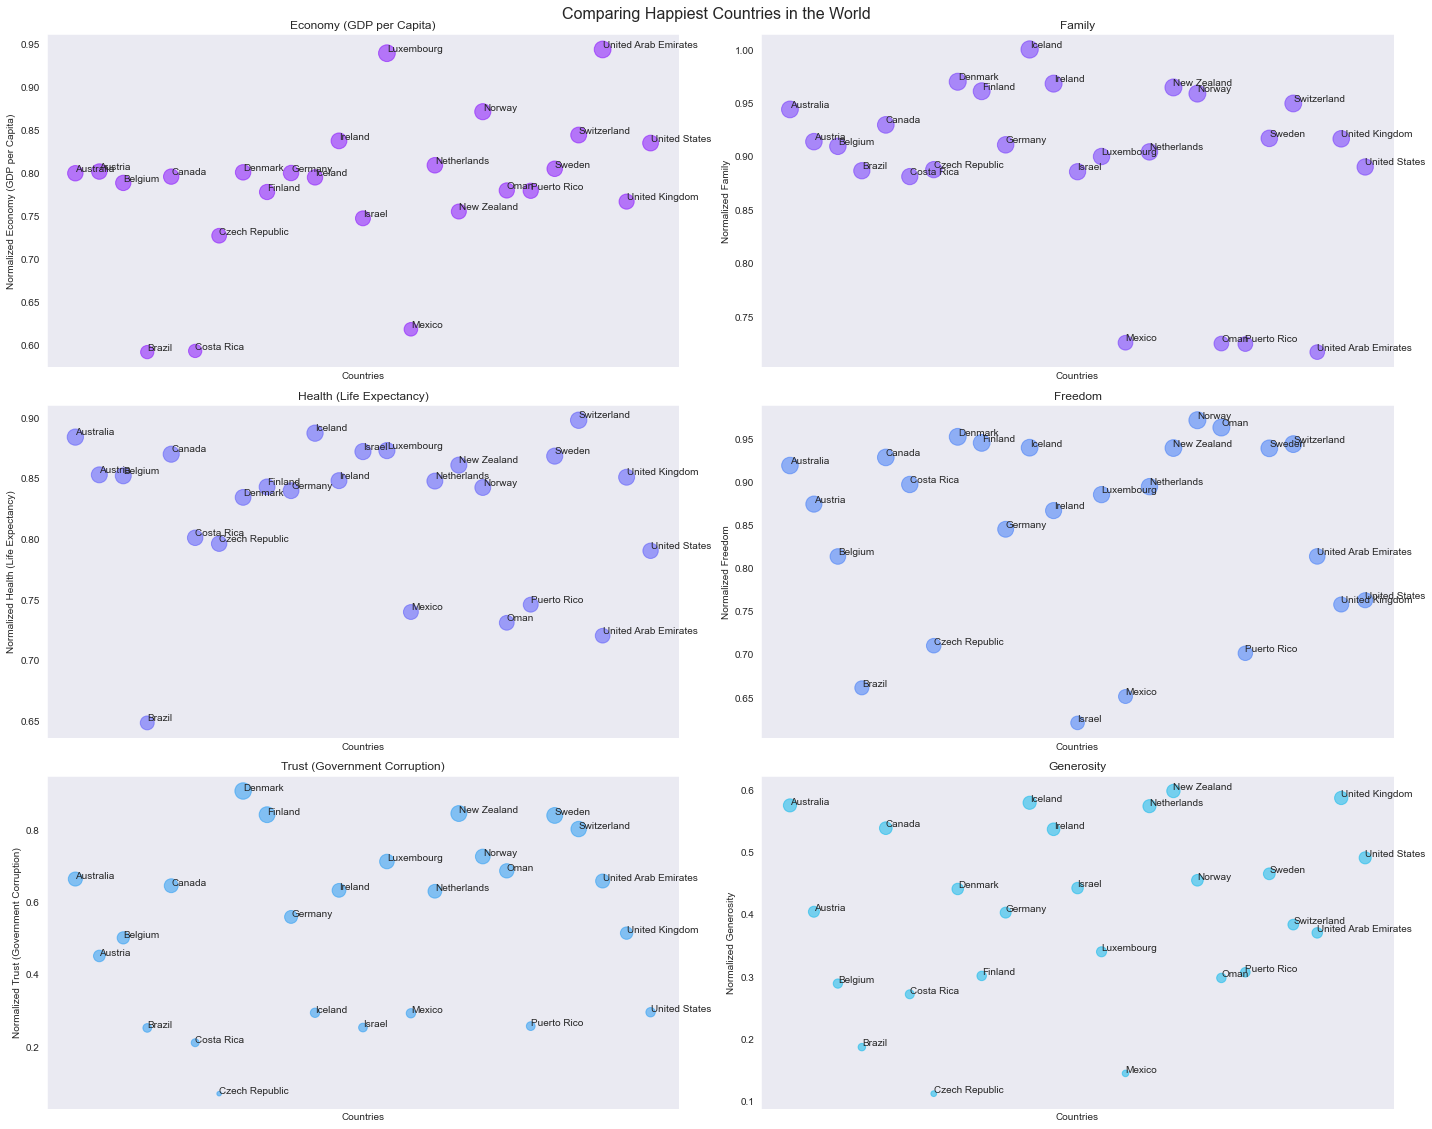

In [6]:
# Resetting the index for conveniece
df_happy_countries_mean = df_mean[df_mean['Happiness Score'] >= 0.8].reset_index(drop=True)
markerindex = [',', 'x', '+', 'v', '^', '<', '>', 's', 'd']

# Plotting the normalized column features in order to understand what factors in general make the countries happy
plt.figure(figsize=(20, 16))
fig_num=1
for i, col in enumerate(cols_to_investigate):
    if col != 'Happiness Score':
        plt.subplot(3, 2, fig_num)
        plt.tight_layout()
        plt.scatter(range(len(df_happy_countries_mean)), df_happy_countries_mean[col], s=300 * df_happy_countries_mean[col],
                   color=colors[i], alpha=0.5)
        
        plt.xlabel('Countries')
        plt.ylabel('Normalized '+col)
        
        for x, y, country, in zip(range(len(df_happy_countries_mean)), df_happy_countries_mean[col], df_happy_countries_mean['Country']):
            plt.text(x+0.002, y+0.002, country)
        plt.title(col)
        plt.xticks([])
        fig_num += 1
    plt.suptitle("Comparing Happiest Countries in the World", size=16)
    plt.savefig('./plots/Comparing_Happiest_Countries_in_the_World.png', bbox_inches='tight')

##### 2 Common factors amongst happiest countries

Based on the above plots not including the anomalies all the happiest countries have a common trend of high GDP, high life expectancy, high freedom, high trust on the goverment and some aspect of generosity. One of the most important factors seems to be Family with some exceptions to it.

##### 3 Are there any anomalies amongst these happy countries?

Countries like Brazil, Costa Rica and Mexico have very unusual behavior. They have very low GDP, freedom and trust on government compared to other happy countries. But also in the countries like Brazil and Costa Rica family palys are very important role in happiness. In countries like mexico an assumption can be made that people just choose to be happy no matter the circumstances and for some countries like Brazil and Costa Rica family plays a vital role. Thus for some countries happiness is a choice where as for some it comes with freedom, security and family. 

--------------------------------------
This section tries to analyze which countries are quickly turning into happy countries
##### Q4. Happy countries in the making

###### Dealing with the Categorical Variables
Since there are two categorical variables namely ```Country``` and ```Year``` I converted them to categorical codes.

In [7]:
# Dealing with Categorical variables "Country" and "Year"
only_objects = df.select_dtypes(include=['object']).copy()
only_objects["Country"] = only_objects["Country"].astype('category')
only_objects["Year"] = only_objects["Year"].astype('category')
df["Country_code"] = only_objects["Country"].cat.codes
df["Year_code"] = only_objects["Year"].cat.codes

Since each country is a mini time series, I decided to add new features to the dataframes with the difference between consective years and  shifted consective years. In case where there was no data, I filled those cells with 0 since data was not available. Although it would be interesting to see the effect of imputing the data with mean along the time axis. The cell below perform adding new diff features

In [8]:
new_cols_to_investigate = cols_to_investigate + ['Happiness Rank']

df_new_features = df.copy().reset_index(drop=True)

for each_col in new_cols_to_investigate:
    df_new_features['Last_Year_' + each_col] = df_new_features.groupby(['Country_code'])[each_col].shift()
    df_new_features['Last_Year_Diff' + each_col] = df_new_features[each_col] - df_new_features['Last_Year_' + each_col]
    df_new_features['Last_Year-1_' + each_col] = df_new_features.groupby(['Country_code'])[each_col].shift(2)
    df_new_features['Last_Year-1_Diff' + each_col] = df_new_features[each_col] - df_new_features['Last_Year-1_' + each_col]
    df_new_features['Last_Year-2_' + each_col] = df_new_features.groupby(['Country_code'])[each_col].shift(3)
    df_new_features['Last_Year-2_Diff' + each_col] = df_new_features[each_col] - df_new_features['Last_Year-2_' + each_col]
    df_new_features['Last_Year-3_' + each_col] = df_new_features.groupby(['Country_code'])[each_col].shift(4)
    df_new_features['Last_Year-3_Diff' + each_col] = df_new_features[each_col] - df_new_features['Last_Year-3_' + each_col]
    df_new_features = df_new_features.fillna(0)

Now that we have the consecutive and shifted consecutive diffs of different features we want to investigate, it is easier to analyze countries that are quickly climbing the ladded in the happiness score and ranks.

In [9]:
# Computing the mean accumulated change in the happiness score
latest_df = df_new_features[df_new_features['Year'] == '2019'].copy()
diff_happiness_cols = ['Last_Year_DiffHappiness Score', 'Last_Year-1_DiffHappiness Score',
                       'Last_Year-2_DiffHappiness Score', 'Last_Year-3_DiffHappiness Score']
diff_happiness_ranks = ['Last_Year_DiffHappiness Rank', 'Last_Year-1_DiffHappiness Rank',
                       'Last_Year-2_DiffHappiness Rank', 'Last_Year-3_DiffHappiness Rank']
latest_df['accumulated_change_happiness_score'] = latest_df[diff_happiness_cols].mean(axis=1)
latest_df['accumulated_change_happiness_rank'] = latest_df[diff_happiness_ranks].mean(axis=1)

# Sorting for display purposes
latest_sorted_df = latest_df.sort_values(['accumulated_change_happiness_score','Happiness Rank'], ascending=False)
### Top 10 happiest countries in the making
happy_countries_in_making = latest_sorted_df.head(10).sort_values(['Happiness Rank'], ascending=True)['Country'].values
print("Top 10 Happy countries in making: ", happy_countries_in_making)

Top 10 Happy countries in making:  ['Kosovo' 'Honduras' 'Ivory Coast' 'Benin' 'Cambodia' 'Niger'
 'Burkina Faso' 'Guinea' 'Togo' 'Burundi']


Visulazing the countries based on accumulated cumulative change in the happiness score

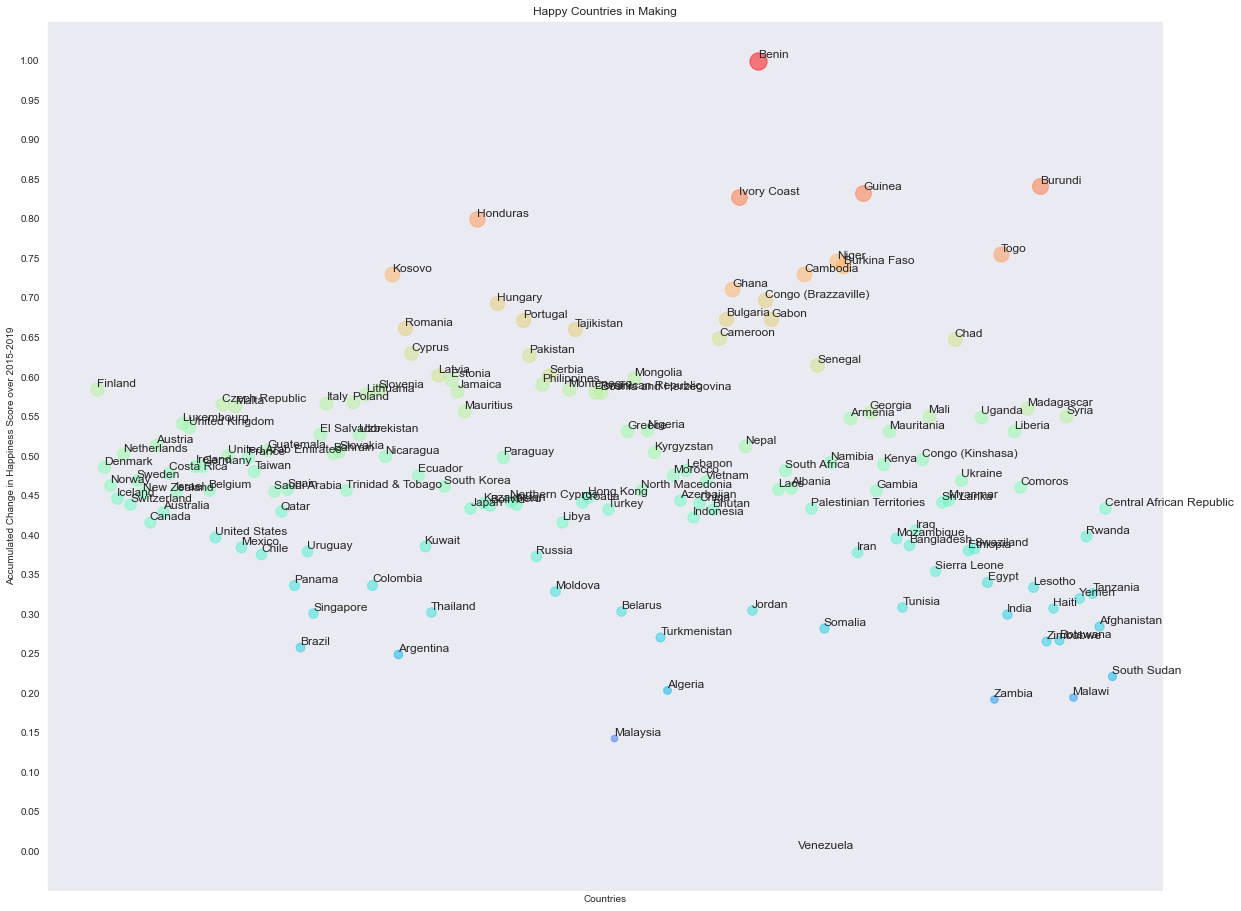

In [10]:
# Normalizing the accumulated change in happiness score for visualization purposes
all_countries = latest_df['Country']
ll = latest_df['accumulated_change_happiness_score'].min()
hl = latest_df['accumulated_change_happiness_score'].max()
latest_df['norm_change_happiness_score'] = (latest_df['accumulated_change_happiness_score'] - ll) / (hl - ll)
colors = cm.rainbow(np.arange(0, 1+0.05, 0.05))
custom_bins = np.arange(0, 1+0.05, 0.05)

# Plotting the happy countries in making
plt.figure(figsize=(20, 16))
for i in range(0, len(all_countries)):
    obj = latest_df.iloc[i]
    score, country = obj['norm_change_happiness_score'], obj['Country']
    color_index = np.argwhere(score <= custom_bins)[0][0]
    plt.scatter(i, score, s=300*score, color=colors[color_index], alpha=0.5)
    plt.text(i+.003, score+.003, country, fontsize=12)
plt.yticks(np.arange(0, 1+0.05, 0.05))
plt.xticks([])
plt.xlabel('Countries')
plt.ylabel('Accumulated Change in Happiness Score over 2015-2019')
plt.title('Happy Countries in Making')
plt.savefig('./plots/Happy_Countries_in_Making.png', bbox_inches='tight')

##### 4.1 This a sub question of 4. which deals with comparing the happy countries in the making

In [11]:
# Normalizing diff features for visualization purposes
for each_col in cols_to_investigate:
    diff_cols = [col+each_col for col in ['Last_Year_Diff', 'Last_Year-1_Diff',
                       'Last_Year-2_Diff', 'Last_Year-3_Diff']]
    latest_df['accumulated_change_'+each_col] = latest_df[diff_cols].mean(axis=1)

for each_col in cols_to_investigate:
    ll = latest_df['accumulated_change_'+each_col].min()
    hl = latest_df['accumulated_change_'+each_col].max()
    latest_df['norm_change_'+each_col] = (latest_df['accumulated_change_'+each_col] - ll) / (hl - ll)

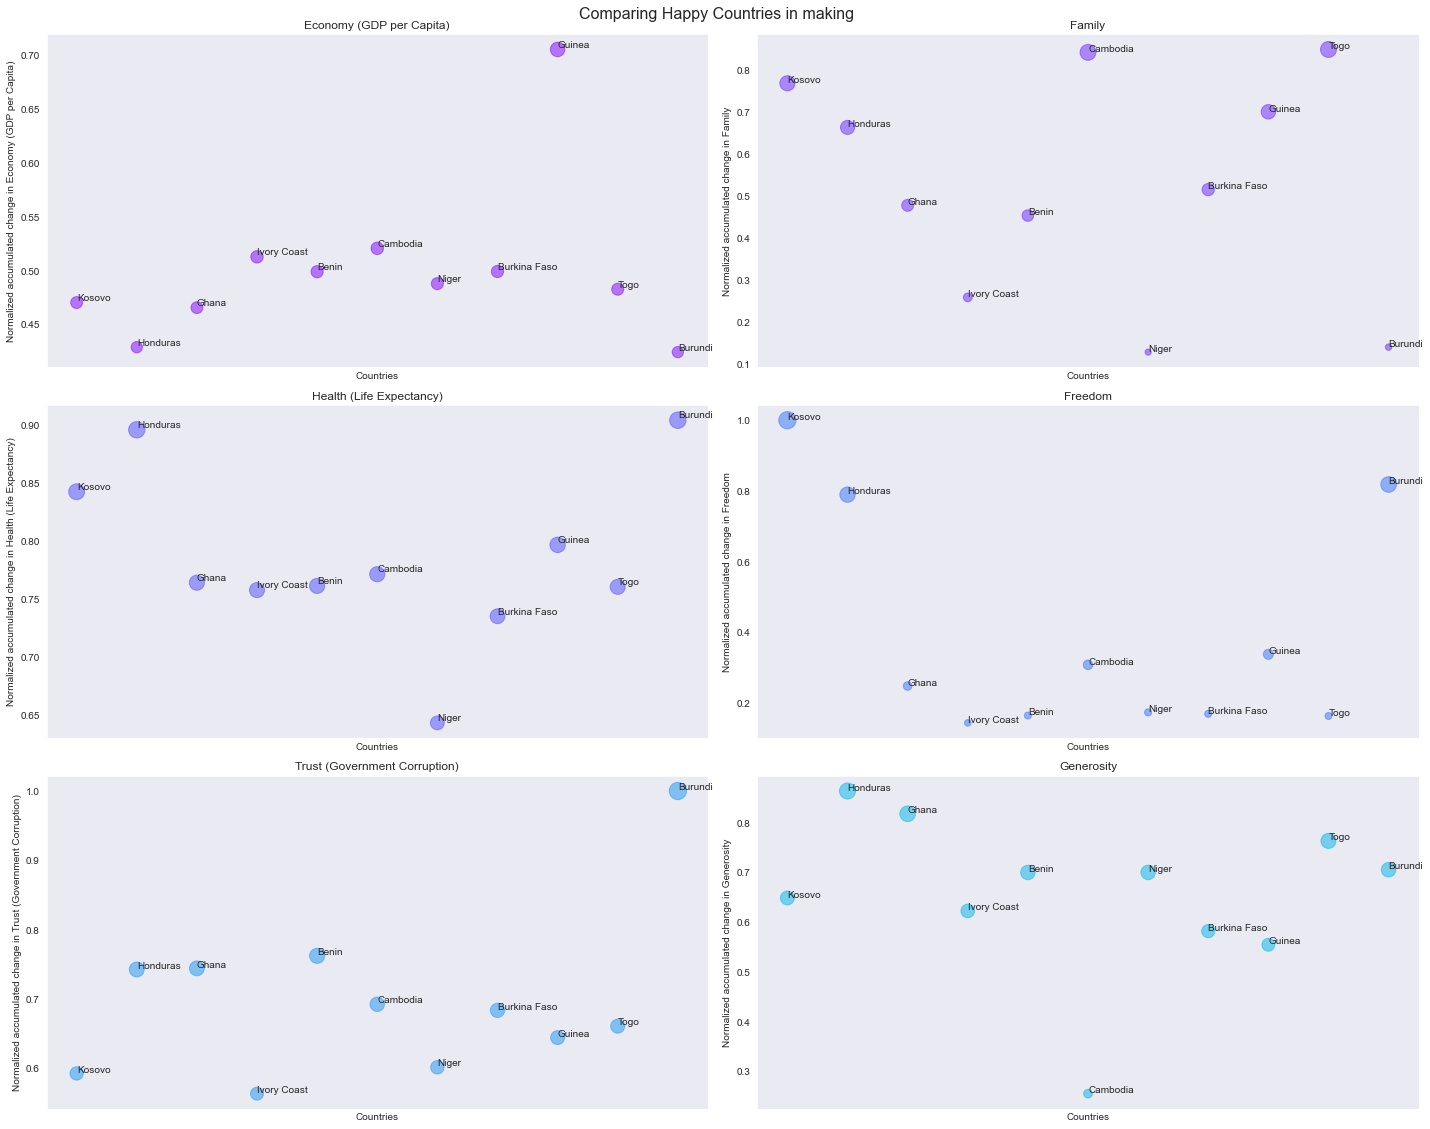

In [12]:
df_happy_countries_in_making = latest_df[latest_df['norm_change_Happiness Score'] >= 0.7].reset_index(drop=True)

# plot to compare happy countries in making
plt.figure(figsize=(20, 16))
fig_num=1
for i, col in enumerate(cols_to_investigate):
    if col != 'Happiness Score':
        plt.subplot(3, 2, fig_num)
        plt.tight_layout()
        plt.scatter(range(len(df_happy_countries_in_making)), df_happy_countries_in_making['norm_change_'+col], s=300 * df_happy_countries_in_making['norm_change_'+col],
                   color=colors[i], alpha=0.5)
        plt.xlabel('Countries')
        plt.ylabel('Normalized accumulated change in '+col)
        for x, y, country, in zip(range(len(df_happy_countries_in_making)), df_happy_countries_in_making['norm_change_'+col], df_happy_countries_in_making['Country']):
            plt.text(x+0.002, y+0.002, country)
        plt.title(col)
        plt.xticks([])
        fig_num += 1
    plt.suptitle("Comparing Happy Countries in making", size=16)
    plt.savefig('./plots/Comparing_Happy_Countries_in_making.png', bbox_inches='tight')

###### Analysis on 4. Happy Countries in the making

Top 10 happy countries in the making are ['Kosovo' 'Honduras' 'Ivory Coast' 'Benin' 'Cambodia' 'Niger'
 'Burkina Faso' 'Guinea' 'Togo' 'Burundi'], based on the trend. But this list doesn't also give the complete picture since there are already countries on the top and these countries were in the bottom of the list and the scope of improvement in these countries is also quite high. Also, one of the other common observations was that the scope for improvement saturates after reaching certain threshold and this could be seen in the countries which are already happy like ['Australia' 'Austria' 'Belgium' 'Canada'
 'Czech Republic' 'Denmark' 'Finland' 'Germany' 'Iceland' 'Ireland'
 'Israel' 'Luxembourg' 'Mexico' 'Netherlands' 'New Zealand' 'Norway'
 'Oman' 'Puerto Rico' 'Sweden' 'Switzerland' 'United Arab Emirates'
 'United Kingdom' 'United States'].

Another trend which could be seen happy countries in making is that Family and life expectancy play a very important role. Thus at this point we can safely hypothesize that family and life expectancy plays a very important role in happiness.


------------------------------------------------------------------------------------------

#### 5 Fitting the model 

In [13]:
for each_col in cols_to_investigate:
    diff_cols = [col+each_col for col in ['Last_Year_Diff', 'Last_Year-1_Diff',
                       'Last_Year-2_Diff', 'Last_Year-3_Diff', 'Last_Year_', 'Last_Year-1_', 'Last_Year-2_', 'Last_Year-3_']]
    for col in diff_cols:
        df_new_features[col].fillna(0, inplace=True)

In [14]:
# Cols to use in X and cols to predict in y
x_cols = [
       'Economy (GDP per Capita)', 'Family', 'Health (Life Expectancy)',
       'Freedom', 'Trust (Government Corruption)', 'Generosity','Country_code', 'Year_code',
       'Last_Year_Economy (GDP per Capita)',
       'Last_Year_DiffEconomy (GDP per Capita)',
       'Last_Year-1_Economy (GDP per Capita)',
       'Last_Year-1_DiffEconomy (GDP per Capita)',
       'Last_Year-2_Economy (GDP per Capita)',
       'Last_Year-2_DiffEconomy (GDP per Capita)',
       'Last_Year-3_Economy (GDP per Capita)',
       'Last_Year-3_DiffEconomy (GDP per Capita)', 'Last_Year_Family',
       'Last_Year_DiffFamily', 'Last_Year-1_Family', 'Last_Year-1_DiffFamily',
       'Last_Year-2_Family', 'Last_Year-2_DiffFamily', 'Last_Year-3_Family',
       'Last_Year-3_DiffFamily', 'Last_Year_Health (Life Expectancy)',
       'Last_Year_DiffHealth (Life Expectancy)',
       'Last_Year-1_Health (Life Expectancy)',
       'Last_Year-1_DiffHealth (Life Expectancy)',
       'Last_Year-2_Health (Life Expectancy)',
       'Last_Year-2_DiffHealth (Life Expectancy)',
       'Last_Year-3_Health (Life Expectancy)',
       'Last_Year-3_DiffHealth (Life Expectancy)', 'Last_Year_Freedom',
       'Last_Year_DiffFreedom', 'Last_Year-1_Freedom',
       'Last_Year-1_DiffFreedom', 'Last_Year-2_Freedom',
       'Last_Year-2_DiffFreedom', 'Last_Year-3_Freedom',
       'Last_Year-3_DiffFreedom', 'Last_Year_Trust (Government Corruption)',
       'Last_Year_DiffTrust (Government Corruption)',
       'Last_Year-1_Trust (Government Corruption)',
       'Last_Year-1_DiffTrust (Government Corruption)',
       'Last_Year-2_Trust (Government Corruption)',
       'Last_Year-2_DiffTrust (Government Corruption)',
       'Last_Year-3_Trust (Government Corruption)',
       'Last_Year-3_DiffTrust (Government Corruption)', 'Last_Year_Generosity',
       'Last_Year_DiffGenerosity', 'Last_Year-1_Generosity',
       'Last_Year-1_DiffGenerosity', 'Last_Year-2_Generosity',
       'Last_Year-2_DiffGenerosity', 'Last_Year-3_Generosity',
       'Last_Year-3_DiffGenerosity']

y_cols = ['Happiness Score']


for col in x_cols:
    df_new_features[col].fillna(0, inplace=True)

# Preparing the final dataframe
df_predict = df_new_features.copy()
df_predict = df_predict.reset_index(drop=True)

In [15]:
#Split into explanatory and response variables
X = df_predict[x_cols]
y = df_predict[y_cols]

#Split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .10, random_state=30) 

lm_model = LinearRegression(normalize=True) # Instantiate
lm_model.fit(X_train, y_train) #Fit
        
#Predict and score the model
y_test_preds = lm_model.predict(X_test) 
"The r-squared score for the model using only quantitative variables was {} on {} values.".format(r2_score(y_test, y_test_preds), len(y_test))

'The r-squared score for the model using only quantitative variables was 0.6373004834946869 on 79 values.'

--------------------------------------------------------------------------
#### 6. Evaluting our hypothesis after data analysis about  "Family" and "Freedom" playing an important role in predicting happiness

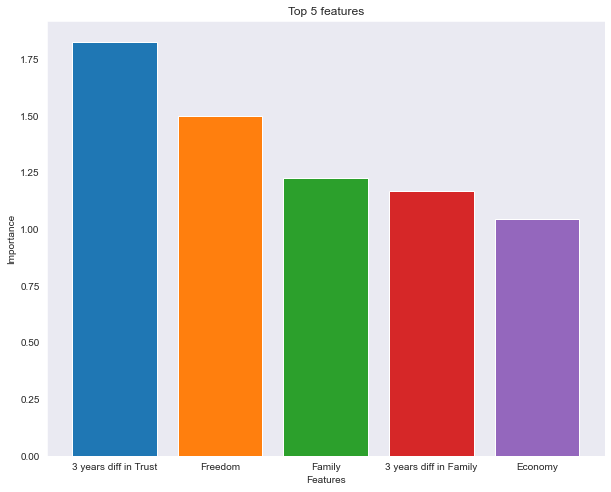

In [16]:
### Exploring feature importance

importance = lm_model.coef_
importance = importance.squeeze()
features_importance = {x_cols[i] : v for i, v in enumerate(importance)}

# Getting top 5 features
features_importance = dict(sorted(features_importance.items(), key=lambda item: item[1], reverse=True))
top_features = list(features_importance.keys())[:5]

# Plotting the top 5 features
plt.figure(figsize=(10, 8))
for i, each_feature in enumerate(top_features):
    plt.bar(i, features_importance[each_feature])

top_features[0] = '3 years diff in Trust'
top_features[3] = '3 years diff in Family'
top_features[-1] = 'Economy'
plt.xticks(list(range(5)), top_features)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Top 5 features')
plt.savefig('./plots/Top_5.png', bbox_inches='tight')